In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 2 
import sys, os, glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt, datetime as dt


from CAP.caliop import *
from CAP.collocation import *
import cartopy.crs as ccrs

from contrails.satellites.goes.reprojection import *
from contrails.satellites.goes.abi import *

from skimage.morphology import binary_dilation

import matplotlib.patches as mpatches
import colormaps
from matplotlib.colors import Normalize, LogNorm


def get_mask(time, conus=False):

    if conus:
        path = "/net/d13/data/vmeijer/data/orthographic_detections_goes16/" \
                + "ABI-L2-MCMIPC" + time.strftime("/%Y/%j/%H/%Y%m%d_%H_%M.csv")
        try:
            df = pd.read_csv(path) 
        except FileNotFoundError as e:
            raise FileNotFoundError(f"No detection found at {path}")
            
        mask = np.zeros((2000, 3000))
        mask[df.row.values, df.col.values] = 1
        return mask
    else:
        df = pd.read_csv("/home/vmeijer/covid19/data/predictions_wo_sf/" + time.strftime('%Y%m%d.csv'))
        df.datetime = pd.to_datetime(df.datetime)
        df = df[df.datetime == time]
        mask = np.zeros((2000, 3000))
        mask[df.x.values, df.y.values] = 1
        return mask

In [5]:
fine_df = pd.read_pickle("figure1_data.pkl")
diffs = fine_df["profile_id"].diff().values
diffs[0] = 0
diffs[diffs <= 1] = 0


diffs[diffs > 1 ] = 1

fine_df["contrail_id"] = np.cumsum(diffs)

In [6]:
goes_time = fine_df.iloc[0].goes_time
conus = True

nc = xr.open_dataset(get_reprojection_path(goes_time, product="ABI-L2-MCMIPC"))
ash = ash_from_nc(nc)

In [8]:
ca = CALIOP("/net/d15/data/vmeijer/CALIOP_L1/" + fine_df.iloc[0].L1_file)

In [9]:
cloud_filter = ca.get_cloud_filter(extent=[-135, -65, fine_df.iloc[0].segment_start_lat,
                                             51.2],
                                  min_alt=8, max_alt=15)

cross_section_bboxes = []

for cid in fine_df.contrail_id.unique():
    
    sub = fine_df[fine_df.contrail_id == cid]
    
    sub_mask = cloud_filter[:, sub.profile_id.min() - fine_df.segment_start_idx.min(): sub.profile_id.max() - fine_df.segment_start_idx.min()]
    

    sub_mask[200:,:] = 0
    
    bbox = skimage.measure.regionprops((sub_mask > 0).astype(np.uint8))[0].bbox
    
    cross_section_bboxes.append([sub.profile_id.min(), sub.profile_id.max(), bbox[0], bbox[2]])
   

In [14]:
extent = [-135, -45, 48, 51.2]



b532, lons, lats, times = subset_caliop_profile(ca, "Total_Attenuated_Backscatter_532",
                                        extent, return_coords=True)



extent[0] = lons.min()
extent[1] = lons.max()
extent[0] = -98
extent[1] = -95
extent[2] = 48

mask = get_mask(goes_time, conus=conus)

abi_ids = get_ortho_ids()


rel_rows, rel_cols = np.where(np.isin(abi_ids,fine_df["goes_ABI_id"].values))

ccl = skimage.measure.label(mask)
abi_ids = get_ortho_ids()

rel_rows, rel_cols = np.where(np.isin(abi_ids,fine_df["goes_ABI_id"].values))

rel_cids = np.unique(ccl[rel_rows, rel_cols])[1:]
                                            

subset = ccl * np.isin(ccl, rel_cids)
boundaries = binary_dilation(subset > 0 ) - (subset > 0).astype(np.int8)
b_ids = skimage.measure.label(boundaries)

boundaries = binary_dilation(mask) - mask







In [15]:
import matplotlib.patheffects as pe

In [16]:
plt.rc("font", size=8)

/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/vmeijer/.conda/envs/gspy/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


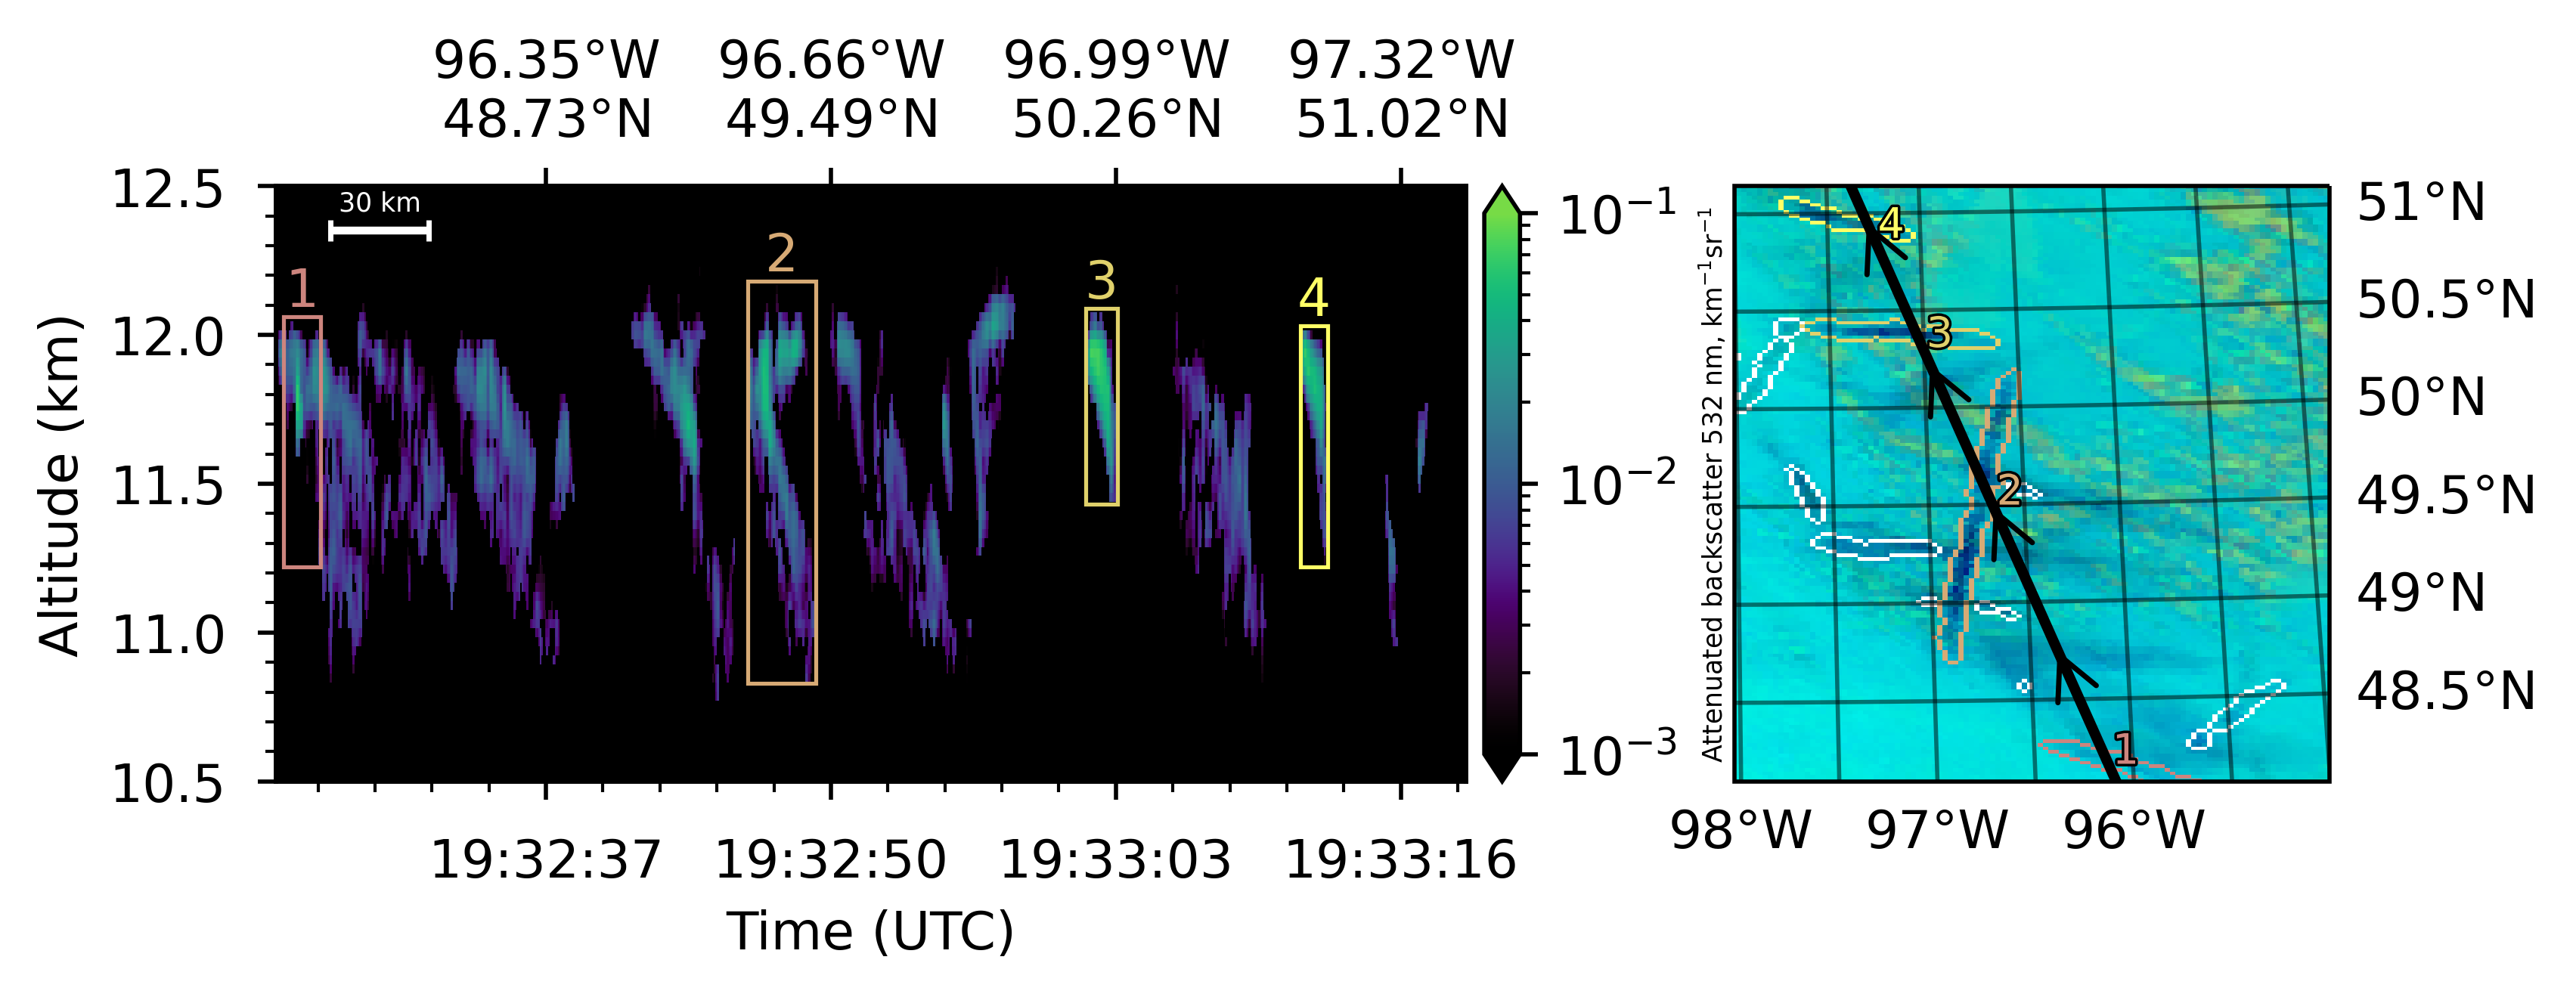

In [18]:
fig = plt.figure(dpi=500, figsize=(4.72441, 4.72441/3))
ax = fig.add_axes([0, 0, 2/3, 1])

# ca.plot_backscatter(colorbar=False, cloud_filter=True, fig=fig, ax=ax, min_alt=10.5,
#        max_alt=12.5, dist_axis=True, extent=[-135, -65, 48,
#                                              51.2])

norm = LogNorm(1e-3, 1e-1)
plot_caliop_profile_direct(fig, ax, lons, lats, times, data, cmap=colormaps.lavender, norm=norm,
                          min_alt=10.5, max_alt=12.5)

# Add 200 m to cloud top positions for clarity, and only show every other for clairty
# ax.scatter(fine_df.profile_id.values[::2] - fine_df.iloc[0].segment_start_idx,
#            fine_df.caliop_top_height.values[::2] / 1000 + 0.2, c=colormaps.ember(fine_df.contrail_id.values[::2]/6), cmap=colormaps.ember, label="Collocated positions", marker="v",
#           ec="k")
# ax.legend(loc="upper right", bbox_to_anchor=(1,1), frameon=True)

#counter = 0

colors = [colormaps.buda(0.5), colormaps.buda(4/6), colormaps.buda(5/6), colormaps.buda(1.0)]

for counter, bbox in enumerate(cross_section_bboxes):
    
    if counter >= 3:
        ax.add_patch(mpatches.Rectangle([bbox[0] - 12756, 15 - bbox[-1] * 0.030], width=bbox[1]-bbox[0], height=0.030*(bbox[-1]-bbox[2]),
                                   fill=None, ec=colors[counter-3], linewidth=0.75))
        
        ax.text(bbox[0] + 0.5 * (bbox[1] - bbox[0]) - 12756, 15 - bbox[2] * 0.030, str(counter-2),
                color=colors[counter-3],
                ha="center", va="bottom"
               )
    #counter += 1

ax.tick_params(axis="y", direction="out", which="both")
    
gax = fig.add_axes([2/3 + 0.15, 0, 1/3, 1], projection=ORTHO_PROJ)
gax.imshow(ash, extent=ORTHO_EXTENT, origin='upper', transform=ORTHO_PROJ)
gax.imshow(np.ma.masked_array(boundaries, mask=(boundaries==0.)), extent=ORTHO_EXTENT,
           origin='upper', transform=ORTHO_PROJ, cmap="gray_r")


#b_ids[b_ids > 0] += 1
gax.imshow(1.0 * (7-np.ma.masked_array(b_ids, mask=b_ids==0.0)), extent=ORTHO_EXTENT,
          origin='upper', transform=ORTHO_PROJ, cmap=colormaps.buda, vmin=0, vmax=6)

gax.set_extent([extent[0], extent[1], extent[2]+0.1, extent[3]-0.1], ccrs.PlateCarree())
gax.set_aspect('auto')
gl = gax.gridlines(draw_labels=True, color='k', alpha=0.5)
gl.xlabels_top = False
gl.ylabels_left = False 

gax.plot(lons, lats, transform=ccrs.PlateCarree(), c="k", linewidth=2, label="CALIPSO ground track", zorder=3,
        )

transform = ccrs.Geodetic()._as_mpl_transform(gax)
for pp in [250, 500, 750, 1000]:
    
    gax.annotate("",xytext=(lons[pp],lats[pp]), xy=(lons[pp+5], lats[pp+5]), arrowprops=dict(arrowstyle="->",
                                                                                           color="k"),
               size=20, xycoords=transform)




counter = 1
for cid in fine_df.contrail_id.unique()[3:]:
    
    sub = fine_df[fine_df.contrail_id == cid]
    
    first_lon = sub.iloc[-1].caliop_lon
    first_lat = sub.iloc[-1].caliop_lat
    
    gax.text(first_lon, first_lat, str(int(counter)),transform=ccrs.Geodetic(),
                ha="left",va="bottom", zorder=5, color=colors[counter-1],
             path_effects=[pe.withStroke(linewidth=1, foreground="k")], size=8)
    
    counter += 1

#ax.annotate("(a)", %b)
pos = ax.get_position()
cax = fig.add_axes([pos.x1+0.01, pos.y0 , 0.02, pos.y1-pos.y0])

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormaps.lavender), cax=cax,
             label=r"Attenuated backscatter 532 nm, km${}^{-1}$sr${}^{-1}$", extend="both")

cbar.set_label(r"Attenuated backscatter 532 nm, km${}^{-1}$sr${}^{-1}$", fontsize=5)


ax.errorbar(95, 12.35, xerr=45, c="w", capsize=2.0)
ax.annotate("30 km", (95, 12.4), ha="center", va="bottom", c="w", size=5)

plt.savefig("fig01.png", dpi=500, bbox_inches="tight")